In [2]:
import matplotlib
import numpy as np
import psutil
import os
import seaborn as sns
import time
import sys

import matplotlib.pyplot as plt
import numpy.linalg as la

# add src directory to path
sys.path.append(os.path.join(os.getcwd(), 'src'))

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

## Parameters

In [7]:
psutil.cpu_count(logical=True)

24

In [8]:
from objectives import ObjMSE, ObjRidge

iterations = 800
num_workers = 40
it_check = 40
n_seeds = 5
max_seed = 424242
rng = np.random.default_rng(42)
seeds = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(n_seeds)]
seed_to_run = {}
for r, seed in enumerate(seeds):
    seed_to_run[seed] = r
    
n_data = 10000
dim = 400
batch_size = 256
noise_scale = 1e-5

objective = ObjMSE(n_data, dim, noise_scale=noise_scale, batch_size=batch_size)


## Synchronous

In [ ]:
from runs import run


In [16]:

lr_mini = 0.19 # best tuned
lr_decay = 0
its_, ts_, losses_, _ = run(objective, seeds, num_workers, lr=lr_mini, lr_decay=lr_decay, iterations=iterations, 
                            asynchronous=False, delay_adaptive=False, it_check=it_check, batch_size=batch_size, one_bad_worker=False)

2023-06-10 19:56:41,782	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-06-10 19:56:43,690	WARNING worker.py:2019 -- Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [20]:
lr_as = 0.043 # TODO to be tuned
lr_decay = 0
its_as, ts_as, losses_as, _ = run(objective, seeds, num_workers, lr=lr_as, lr_decay=lr_decay, 
                                  iterations=iterations, asynchronous=True, delay_adaptive=False, 
                                  it_check=it_check, batch_size=batch_size, one_bad_worker=False)

2023-06-10 19:58:19,662	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-06-10 19:58:21,443	WARNING worker.py:2019 -- Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [22]:
lr_ad = 0.043 # TODO to be tuned
lr_decay = 0
its_ad, ts_ad, losses_ad, delays = run(objective, seeds, num_workers, lr=lr_ad, lr_decay=lr_decay, 
                                       iterations=iterations, asynchronous=True, delay_adaptive=True, 
                                       it_check=it_check, batch_size=batch_size, one_bad_worker=False)

2023-06-10 19:59:14,762	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-06-10 19:59:16,529	WARNING worker.py:2019 -- Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


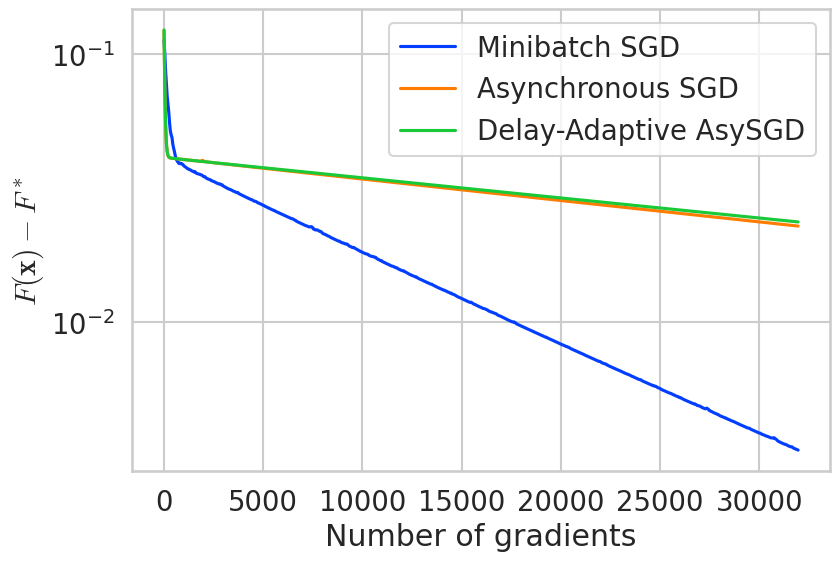

In [23]:
plt.plot(its_ * num_workers, losses_ - f_min, label='Minibatch SGD')
plt.plot(its_as, losses_as - f_min, label='Asynchronous SGD')
plt.plot(its_ad, losses_ad - f_min, label='Delay-Adaptive AsySGD')
plt.yscale('log')
plt.legend()
plt.xlabel('Number of gradients')
plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')
plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


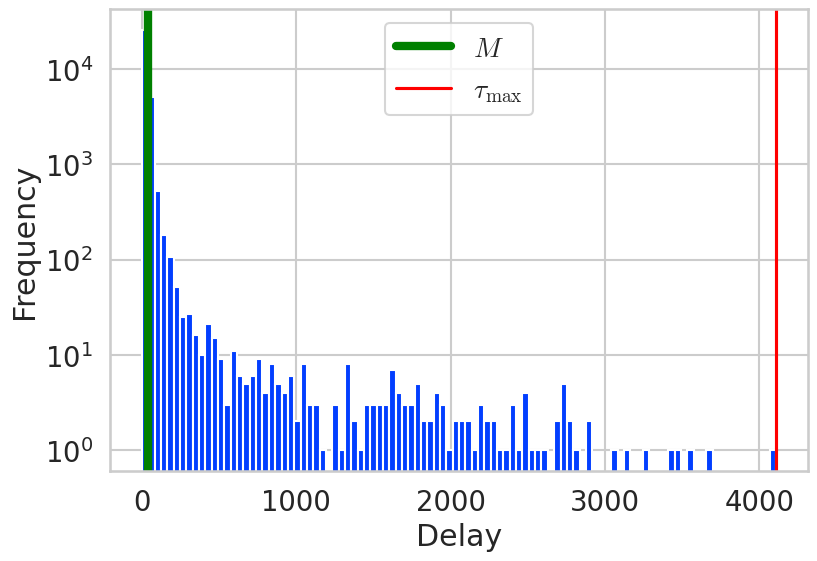

In [24]:
plt.hist(delays, bins=100)
plt.axvline(num_workers, color='green', label=r'$M$', linewidth=6)
plt.axvline(np.max(delays), color='red', label=r'$\tau_{\max}$')
plt.xlabel('Delay')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.savefig(f'quadratic_delays_M_{num_workers}_n={n_data}_dim={dim}_bs={batch_size}.pdf', bbox_inches='tight')